In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from lifelines import KaplanMeierFitter

In [2]:
# Define constants
ROUNDING_DIGITS = 2
STARTING_DAY = 580

We need data of single and multiple treatments. For that we used the data of the first study of ['Robust Mouse Rejuvenation' (RMR)](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1). Unfortunately we did not get access to their data set, but their evaluation plots are available [online](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1/study-updates/november-5th-2023-cem49). So lets have a look at it.

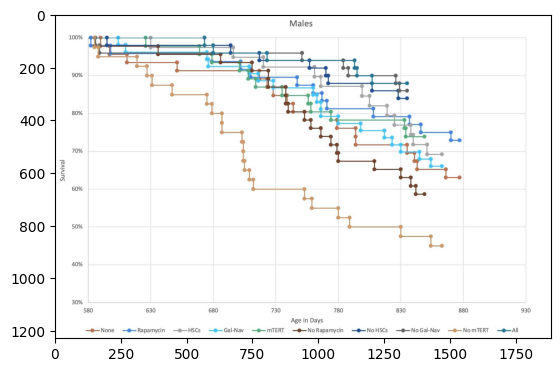

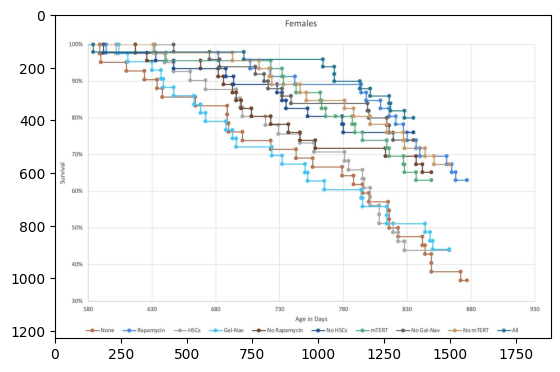

In [3]:
raw_plot_image_male = cv2.imread('Individual Datasets/img/23_12_RMR_Males.jpg')
plt.imshow(raw_plot_image_male)
plt.show()
raw_plot_image_female = cv2.imread('Individual Datasets/img/23_12_RMR_Females.jpg')
plt.imshow(raw_plot_image_female)
plt.show()

We are lucky that there are not that many data points in each plot. So that is why we took the fastest option for us and collected the data points manually. For that we used [plotdigitilizer](https://plotdigitizer.com/).

In [4]:
def loadCSV(path):
    df = pd.read_csv(
        "Individual Datasets/plot_data/female_All.csv",
        skiprows=0,
        sep=",",
        engine="python",
        decimal=".",
        dtype={'x': 'float64', 'y': 'float64'}
        )
    
    # Strip leading/trailing spaces from column names -> e.g. ' y' -> 'y'
    df.columns = df.columns.str.strip()
    return df

df = loadCSV("Individual Datasets/plot_data/female_All.csv")

First you can see that each data point provides a lot of floating point numbers. That comes from the manual elicitation of the data points.
 
That is why we decided to round the points to **2 digits** in our analysis to denoise our data. Furthermore we added the starting point **(580, 1)** by hand. We did this because the study started their interventions with the mice after **18 months**. (See [RMR](https://www.levf.org/projects/robust-mouse-rejuvenation-study-1))

In [5]:
def roundNumbers(df):
    df = df.apply(lambda x:round(x, ROUNDING_DIGITS))
    return df

df = roundNumbers(df)

df

,x,y
0,580.00,1.00
1,583.37,1.00
2,583.99,0.98
3,701.65,0.98
4,702.15,0.96
5,764.07,0.96
6,764.16,0.94
7,773.02,0.92
8,773.29,0.90
9,773.37,0.94


## Sanity Check
We want to see if our data points are representing the data of the figures. We will check this with a plot.

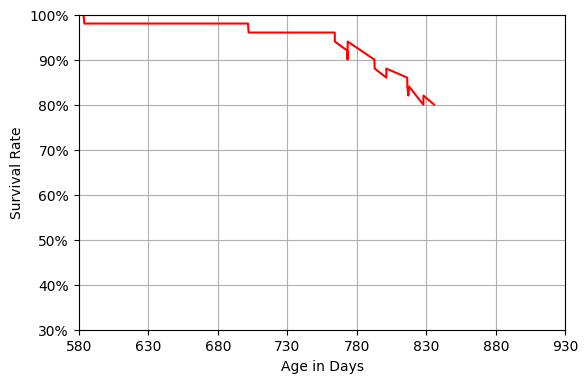

In [6]:
fig, ax = plt.subplots()

# We want to save the image as a .jpg file because the input file is also given as .jpg

# Desired pixel dimensions
width_px = 1884
height_px = 1228
dpi = 300

# Calculate the size in inches. That is necessary because we have to set the figure in inches
width_in = width_px / dpi
height_in = height_px / dpi

x_data = df['x']
y_data = df['y']
ax.plot(x_data, y_data, color='red')

fig.set_size_inches(width_in, height_in)

ax.set_xlim(580, 930)
ax.set_ylim(.3, 1)
ax.set_xticks(np.arange(580, 931, 50))
ax.set_yticks(np.arange(0.3, 1.01, 0.1))
ax.grid(True)
ax.set_xlabel('Age in Days')
ax.set_ylabel('Survival Rate')
#ax.legend(['First line', 'Second line'])

def to_percent(y, position):
    return f"{100 * y:.0f}%"

# Create a formatter and apply it to the y-axis
formatter = FuncFormatter(to_percent)
ax.yaxis.set_major_formatter(formatter)

fig.savefig("./Individual Datasets/img/2401_sanity_check.jpg", dpi=dpi)

In [7]:
# Assuming you have a DataFrame `df` with columns 'duration' for time-to-event data,
# 'event_observed' for the event occurrence (1 if event happened, 0 if censored),
# and 'group' for the different treatment groups.

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))  # Set the figure size as desired

# Fit the model and plot for each group
for treatment in df['group'].unique():
    # Select data for the group
    group_data = df[df['group'] == treatment]
    
    # Fit the data
    kmf.fit(group_data['duration'], group_data['event_observed'], label=treatment)
    
    # Plot the survival function
    kmf.plot(ci_show=False)  # Set ci_show=True if you want to show confidence intervals

# Label the axes and title as in the uploaded image
plt.xlabel('Age in Days')
plt.ylabel('Survival')
plt.title('Kaplan-Meier Survival Curves - Females')
plt.ylim(0.3, 1)  # Adjust the limits as per your data
plt.grid(True)  # If you want to display the grid

# Show the plot
plt.show()

KeyError: 'group'

<Figure size 1000x600 with 0 Axes>

In [ ]:
sanity_check_female = cv2.imread('Individual Datasets/img/2401_sanity_check.jpg')
plt.figure()

# Display the first image
plt.imshow(raw_plot_image_female)

# Overlay the second image with 50% opacity
plt.imshow(sanity_check_female, alpha=0.5)

In [10]:
def addTableToDataFrame(df, path, sex, category):
    tabledf = loadCSV(path)
    roundNumbers(tabledf)
    addColumn(tabledf, 'sex', sex)
    addColumn(tabledf, 'category', category)
    df = pd.concat([df, tabledf], ignore_index=True)
    return df

def addColumn(data_frame, col_name, col_value):
    data_frame[col_name] = col_value

# Add the columns for the first group
addColumn(df, 'sex', 'female')
addColumn(df, 'category', 'All')

# Add the other groups to this data frame
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_Gal-Nav.csv', 'female', 'Gal-Nav')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_HSCs.csv', 'female', 'HSCs')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_mTERT.csv', 'female', 'mTERT')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_no_Gal-Nav.csv', 'female', 'no_Gal_Nav')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_no_HSCs.csv', 'female', 'no_HSCs')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_no_mTERT.csv', 'female', 'no_mTERT')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_no_Rapamycin.csv', 'female', 'no_Rapamycin')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_None.csv', 'female', 'None')
df = addTableToDataFrame(df, 'Individual Datasets/plot_data/female_Rapamycin.csv', 'female', 'Rapamycin')

df

,x,y,sex,category
0,580.000000,1.000000,female,All
1,583.370000,1.000000,female,All
2,583.990000,0.980000,female,All
3,701.650000,0.980000,female,All
4,702.150000,0.960000,female,All
...,...,...,...,...
394,816.978109,0.819288,female,Rapamycin
395,817.550754,0.841324,female,Rapamycin
396,827.730391,0.799832,female,Rapamycin
397,827.911840,0.820723,female,Rapamycin


We do the same for the male data set.

In [11]:
male_df = loadCSV('Individual Datasets/plot_data/male_All.csv')
male_df = roundNumbers(male_df)
addColumn(male_df, 'sex', 'male')
addColumn(male_df, 'category', 'All')

# Add the other groups to this data frame
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_Gal-Nav.csv', 'male', 'Gal-Nav')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_HSCs.csv', 'male', 'HSCs')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_mTERT.csv', 'male', 'mTERT')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_no_Gal-Nav.csv', 'male', 'no_Gal_Nav')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_no_HSCs.csv', 'male', 'no_HSCs')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_no_mTERT.csv', 'male', 'no_mTERT')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_no_Rapamycin.csv', 'male', 'no_Rapamycin')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_None.csv', 'male', 'None')
male_df = addTableToDataFrame(male_df, 'Individual Datasets/plot_data/male_Rapamycin.csv', 'male', 'Rapamycin')

male_df

,x,y,sex,category
0,580.000000,1.000000,male,All
1,583.370000,1.000000,male,All
2,583.990000,0.980000,male,All
3,701.650000,0.980000,male,All
4,702.150000,0.960000,male,All
...,...,...,...,...
205,816.978109,0.819288,male,Rapamycin
206,817.550754,0.841324,male,Rapamycin
207,827.730391,0.799832,male,Rapamycin
208,827.911840,0.820723,male,Rapamycin


Finally we save the data frames as csv files to use them for our further data analyis.

In [13]:
df.to_csv('Individual Datasets/plot_data/female_final.csv', index=False)
male_df.to_csv('Individual Datasets/plot_data/male_final.csv', index=False)